# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from fim_doe import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
model_opt = 'dynamic-DAE'
#model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
#prior_all = np.zeros((4,4))


# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[  28.67892806    5.41249739  -81.73674601  -24.02377324]
 [   5.41249739   26.40935036  -12.41816477 -139.23992532]
 [ -81.73674601  -12.41816477  240.46276004   58.76422806]
 [ -24.02377324 -139.23992532   58.76422806  767.25584508]]
Prior Det: 140189.67370995492
Eigenvalue of the prior experiments FIM: [8.00463185e+02 2.60471503e+02 4.84545259e-01 1.38765050e+00]
Eigenvalue of the prior experiments FIM: [[-0.77629273 -0.54211788  0.31871243 -0.0435912 ]
 [ 0.56614148 -0.80478003 -0.01425817 -0.177791  ]
 [-0.25919275 -0.19059651 -0.94009108  0.11278677]
 [ 0.09834911 -0.14869526  0.12019924  0.97661114]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [ ]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
#sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
sensi_opt = 'sequential_kaug'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True
result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

In [ ]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [ ]:
# this only works for constant T mode. 
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

## Optimization

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, scale_nominal_param_value=True, objective_option='det', L_initial=None)


In [ ]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

## Grid search for 2 design variables

In [ ]:
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

In [ ]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [6]:

design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [7]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

8  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
FIM: [[  29.58003272    5.48612156  -84.54627162  -24.46790912]
 [   5.48612156   27.13328151  -12.64771469 -143.60704229]
 [ -84.54627162  -12.64771469  249.22249067   60.14898186]
 [ -24.46790912 -143.60704229   60.14898186  793.6004921 ]]
Trace: 1099.5362969973296
Determinant: 151638.49432111066
Condition number: 1703.570882096611
Minimal eigen value: 0.48581739042098304
Eigen values: [8.27624360e+02 2.70029455e+02 4.85817390e-01 1.39666420e+00]
Eigen vectors: [[ 0.04300749 -0.31822906 -0.77652374  0.54211761]
 [ 0.17730502  0.01420751  0.56599113  0.80499386]
 [-0.1117473   0.94040674 -0.25890023  0.19004834]
 [-0.97684483 -0.119

### Draw 1D sensitivity curve

In [8]:
test = all_fim.extract_criteria()

Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 300.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 300.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 700.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 700.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 300.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 300.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 700.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 700.0, 500)
Reminder: the  2 th design variable  T  is renamed as  T2 .


["'CA0'", "'T2'"] is/are fixed.
1D sensitivity curve is plotted with  T .


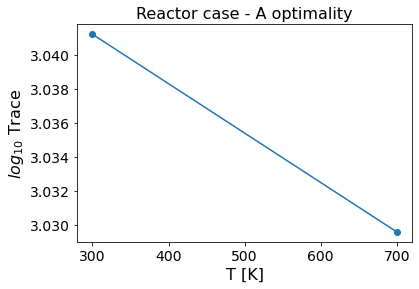

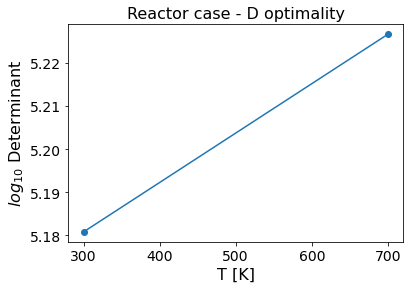

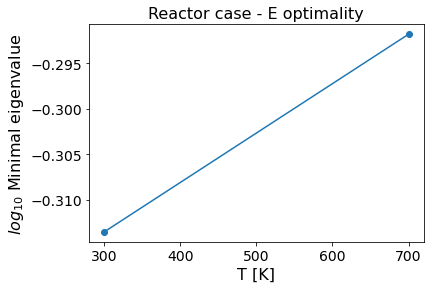

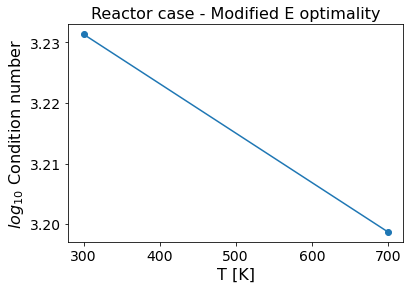

In [9]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

["'T2'"] is/are fixed.
2D heatmap is plotted with  ['CA0', 'T'] .


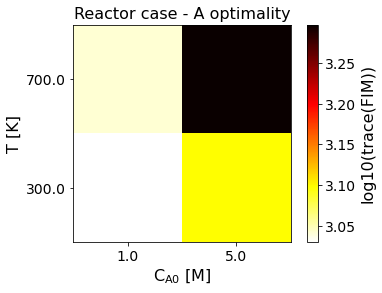

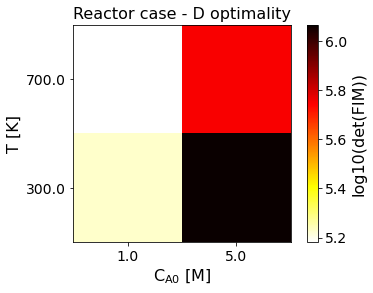

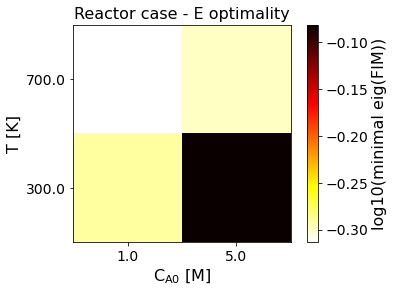

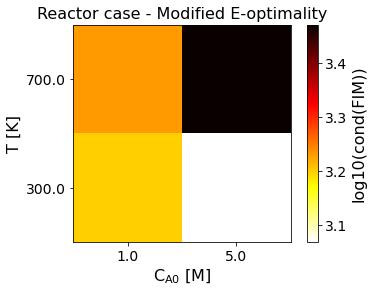

In [10]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )